<a href="https://colab.research.google.com/github/isshii/de4test/blob/test_koyama/DeepXplore_dog%26cat_20200201_ipynb_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# 共通で使うパスなどの定義
# 共通の変数設定
# 共通フォルダパス
data_dir = "/content/gdrive/My Drive/ColabNotebooks/test4ai/data"
data_imagenet_generated = "/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/generated_inputs/"
data_imagenet = "/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet"
data_imagenet_seeds = "/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds"
model_dir = "/content/gdrive/My Drive/ColabNotebooks/test4ai/model"
output_dir = "/content/gdrive/My Drive/ColabNotebooks/test4ai/output"
tmp_dir = "/content/gdrive/My Drive/ColabNotebooks/test4ai/tmp"

In [2]:
# Goggle Drive つなぐ
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15856549153554251922, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1427037879366963099
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 10563780619900726309
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14912199066
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14294065520583271516
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [0]:
# outputフォルダ内容物のクリーンアップ削除
#!rm "$output_dir"/*

In [4]:
import argparse

%tensorflow_version 1.x
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.layers import Input
import imageio
import pandas as pd

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'


Using TensorFlow backend.


In [5]:
#@title デフォルトのタイトル テキスト
# DeepXplore のパラメータ設定部
# read the parameter
# argument parsing
parser = argparse.ArgumentParser(description='Main function for difference-inducing input generation in MNIST dataset')
parser.add_argument('transformation', help="realistic transformation type", choices=['light', 'occl', 'blackout'])
parser.add_argument('weight_diff', help="weight hyperparm to control differential behavior", type=float)
parser.add_argument('weight_nc', help="weight hyperparm to control neuron coverage", type=float)
parser.add_argument('step', help="step size of gradient descent", type=float)
parser.add_argument('seeds', help="number of seeds of input", type=int)
parser.add_argument('grad_iterations', help="number of iterations of gradient descent", type=int)
parser.add_argument('threshold', help="threshold for determining neuron activated", type=float)
parser.add_argument('-t', '--target_model', help="target model that we want it predicts differently",
                    choices=[0, 1, 2], default=0, type=int)
sp_x = 0
sp_y = 0
occl_x = 20
occl_y = 20
parser.add_argument('-sp', '--start_point', help="occlusion upper left corner coordinate", default=(sp_x, sp_y), type=tuple)
parser.add_argument('-occl_size', '--occlusion_size', help="occlusion size", default=(occl_x, occl_y), type=tuple)



_StoreAction(option_strings=['-occl_size', '--occlusion_size'], dest='occlusion_size', nargs=None, const=None, default=(20, 20), type=<class 'tuple'>, choices=None, help='occlusion size', metavar=None)

In [0]:
#@title ノイズのタイプ light / occl / blackout
#@body {light,occl,blackout} weight_diff weight_nc step seeds
#                   grad_iterations threshold
noise_type = "occl" #@param ["light", "occl", "blackout"]
weight_diff = "3.0" #@param {type:"string"}
weight_nc = "3.0" #@param {type:"string"}
step = "1" #@param {type:"string"}
seeds = "10" #@param {type:"string"}
grad_iterations = "100" #@param {type:"string"}
threshold = "0.1" #@param {type:"string"}
#-t = "0" #@param ["0", "1", "2"]




In [0]:
args = parser.parse_args([noise_type, weight_diff, weight_nc, step, seeds, grad_iterations, threshold])

In [0]:
import random
from collections import defaultdict

import numpy as np
from keras import backend as K
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.models import Model
from keras.preprocessing import image
import os, re

import random, string

def randomname(n):
   randlst = [random.choice(string.ascii_letters + string.digits) for i in range(n)]
   return ''.join(randlst)

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    input_img_data = image.img_to_array(img)
    input_img_data = np.expand_dims(input_img_data, axis=0)
    input_img_data = preprocess_input(input_img_data)  # final input shape = (1,224,224,3)
    return input_img_data

def preprocess_image2(img_path):
    img = image.load_img(img_path, target_size=(128, 128))
    input_img_data = image.img_to_array(img)
    input_img_data = np.expand_dims(input_img_data, axis=0)
    input_img_data = preprocess_input(input_img_data)  # final input shape = (1,224,224,3)
    return input_img_data


def deprocess_image(x):
    x = x.reshape((224, 224, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x


def decode_label(pred):
    return decode_predictions(pred)[0][0][1]


def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)


def constraint_occl(gradients, start_point, rect_shape):
    new_grads = np.zeros_like(gradients)
    new_grads[:, start_point[0]:start_point[0] + rect_shape[0],
    start_point[1]:start_point[1] + rect_shape[1]] = gradients[:, start_point[0]:start_point[0] + rect_shape[0],
                                                     start_point[1]:start_point[1] + rect_shape[1]]
    return new_grads


def constraint_light(gradients):
    new_grads = np.ones_like(gradients)
    grad_mean = 1e4 * np.mean(gradients)
    return grad_mean * new_grads


def constraint_black(gradients, rect_shape=(10, 10)):
    start_point = (
        random.randint(0, gradients.shape[1] - rect_shape[0]), random.randint(0, gradients.shape[2] - rect_shape[1]))
    new_grads = np.zeros_like(gradients)
    patch = gradients[:, start_point[0]:start_point[0] + rect_shape[0], start_point[1]:start_point[1] + rect_shape[1]]
    if np.mean(patch) < 0:
        new_grads[:, start_point[0]:start_point[0] + rect_shape[0],
        start_point[1]:start_point[1] + rect_shape[1]] = -np.ones_like(patch)
    return new_grads


def init_coverage_tables(model1, model2, model3):
    model_layer_dict1 = defaultdict(bool)
    model_layer_dict2 = defaultdict(bool)
    model_layer_dict3 = defaultdict(bool)
    init_dict(model1, model_layer_dict1)
    init_dict(model2, model_layer_dict2)
    init_dict(model3, model_layer_dict3)
    return model_layer_dict1, model_layer_dict2, model_layer_dict3


def init_dict(model, model_layer_dict):
    for layer in model.layers:
        if 'flatten' in layer.name or 'input' in layer.name:
            continue
        for index in range(layer.output_shape[-1]):
            model_layer_dict[(layer.name, index)] = False


def neuron_to_cover(model_layer_dict):
    not_covered = [(layer_name, index) for (layer_name, index), v in list(model_layer_dict.items()) if not v]
    if not_covered:
        layer_name, index = random.choice(not_covered)
    else:
        layer_name, index = random.choice(list(model_layer_dict.keys()))
    return layer_name, index


def neuron_covered(model_layer_dict):
    covered_neurons = len([v for v in list(model_layer_dict.values()) if v])
    total_neurons = len(model_layer_dict)
    return covered_neurons, total_neurons, covered_neurons / float(total_neurons)


def scale(intermediate_layer_output, rmax=1, rmin=0):
    X_std = (intermediate_layer_output - intermediate_layer_output.min()) / (
        intermediate_layer_output.max() - intermediate_layer_output.min())
    X_scaled = X_std * (rmax - rmin) + rmin
    return X_scaled


def update_coverage(input_data, model, model_layer_dict, threshold=0):
    layer_names = [layer.name for layer in model.layers if
                   'flatten' not in layer.name and 'input' not in layer.name]

    intermediate_layer_model = Model(inputs=model.input,
                                     outputs=[model.get_layer(layer_name).output for layer_name in layer_names])
    intermediate_layer_outputs = intermediate_layer_model.predict(input_data)

    for i, intermediate_layer_output in enumerate(intermediate_layer_outputs):
        scaled = scale(intermediate_layer_output[0])
        for num_neuron in range(scaled.shape[-1]):
            if np.mean(scaled[..., num_neuron]) > threshold and not model_layer_dict[(layer_names[i], num_neuron)]:
                model_layer_dict[(layer_names[i], num_neuron)] = True
    print("update coverage finished")


def full_coverage(model_layer_dict):
    if False in list(model_layer_dict.values()):
        return False
    return True


def fired(model, layer_name, index, input_data, threshold=0):
    intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    intermediate_layer_output = intermediate_layer_model.predict(input_data)[0]
    scaled = scale(intermediate_layer_output)
    if np.mean(scaled[..., index]) > threshold:
        return True
    return False


def diverged(predictions1, predictions2, predictions3, target):
    if not predictions1 == predictions2 == predictions3:
        return True
    return False

#add
def list_pictures(directory, ext='jpg|jpeg|bmp|png|ppm'):
    return [os.path.join(root, f)
            for root, _, files in os.walk(directory) for f in files
            if re.match(r'([\w]+\.(?:' + ext + '))', f.lower())]

In [0]:
########以下、変更

In [0]:
from keras import models
from keras import optimizers
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19

In [10]:
#model1
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

img_rows, img_cols = 224, 224
input_shape = (img_rows, img_cols, 3)
input_tensor = Input(shape=input_shape)

model1 = Sequential()

model1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

model1.add(Conv2D(128, (3, 3), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

model1.add(Flatten())
model1.add(Dense(512, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.5))
model1.add(Dense(2, activation='softmax',name='model1_output')) # 2 because we have cat and dog classes

model1.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model1_weights = model_dir + '/sample_model1.h5'
model1.load_weights(model1_weights)

model1.summary()













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        25

In [11]:
# モデル2構築
# 参照元 : https://www.kaggle.com/rohit1277/cat-dog-classifier-using-vgg16-transfer-learning
# model名 : good_vgg16.h5
# Dropbox保存先 : https://www.dropbox.com/home/TOPSE/model
# Gdrive保存先 : /content/gdrive/My Drive/ColabNotebooks/test4ai/model

img_rows, img_cols = 224, 224
input_shape = (img_rows, img_cols, 3)
input_tensor = Input(shape=input_shape)

model2 = VGG16(weights='imagenet',input_tensor=input_tensor,include_top=True)

for layers in (model2.layers)[:19]:
    print(layers)
    layers.trainable = False
X= model2.layers[-2].output
predictions1 = Dense(2, activation="softmax",name='model2_output')(X) #出力層のnameを追加
model2 = Model(input = model2.input, output = predictions1)
model2.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

vgg16_weights = model_dir + '/good_vgg16.h5'
model2.load_weights(vgg16_weights)

model2.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("mo...)`
  del sys.path[0]


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [12]:
#resnet50の層が詳細化されているものに変更
#Kerasには詳細化されたモデルのh5ファイルがなかったので、githubのh5ファイルを使用
# model2 = ResNet50(weights='imagenet', include_top=True, input_shape=input_shape)
model3 = ResNet50(weights='imagenet',input_tensor=input_tensor, include_top=True)

#classes = list(iter(batches.class_indices))
model3.layers.pop()
for layer in model3.layers:
    layer.trainable=False
last = model3.layers[-1].output
x = Dense(2, activation="softmax",name='model3_output')(last)
model3 = Model(model3.input, x)
model3.compile(optimizer=optimizers.Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
#finetuned_model.summary()

#resnet_weights = model_dir + '/resnet50_best.h5'
resnet_weights = model_dir + '/resnet50_best.h5'
model3.load_weights(resnet_weights)

model3.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [0]:
#実装見送り20200202

In [0]:
#モデル性能の評価
img_paths = list_pictures("/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/cats_dogs/test/test/test")
img_paths

[]

In [0]:
import os
test_filenames = os.listdir("../content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/cats_dogs/test/test/test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [0]:
!ls "../content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/cats_dogs/train/train/train"

cat.0.jpg      cat.3250.jpg  cat.7751.jpg   dog.12250.jpg  dog.5500.jpg
cat.10000.jpg  cat.3251.jpg  cat.7752.jpg   dog.12251.jpg  dog.5501.jpg
cat.10001.jpg  cat.3252.jpg  cat.7753.jpg   dog.12252.jpg  dog.5502.jpg
cat.10002.jpg  cat.3253.jpg  cat.7754.jpg   dog.12253.jpg  dog.5503.jpg
cat.10003.jpg  cat.3254.jpg  cat.7755.jpg   dog.12254.jpg  dog.5504.jpg
cat.10004.jpg  cat.3255.jpg  cat.7756.jpg   dog.12255.jpg  dog.5505.jpg
cat.10005.jpg  cat.3256.jpg  cat.7757.jpg   dog.12256.jpg  dog.5506.jpg
cat.10006.jpg  cat.3257.jpg  cat.7758.jpg   dog.12257.jpg  dog.5507.jpg
cat.10007.jpg  cat.3258.jpg  cat.7759.jpg   dog.12258.jpg  dog.5508.jpg
cat.10008.jpg  cat.3259.jpg  cat.775.jpg    dog.12259.jpg  dog.5509.jpg
cat.10009.jpg  cat.325.jpg   cat.7760.jpg   dog.1225.jpg   dog.550.jpg
cat.1000.jpg   cat.3260.jpg  cat.7761.jpg   dog.12260.jpg  dog.5510.jpg
cat.10010.jpg  cat.3261.jpg  cat.7762.jpg   dog.12261.jpg  dog.5511.jpg
cat.10011.jpg  cat.3262.jpg  cat.7763.jpg   dog.12262.jpg  dog.55

In [0]:
filenames = os.listdir("../content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/cats_dogs/train/train/train")
filenames

['dog.9107.jpg',
 'dog.9108.jpg',
 'dog.9109.jpg',
 'dog.911.jpg',
 'dog.9110.jpg',
 'dog.9111.jpg',
 'dog.9112.jpg',
 'dog.9113.jpg',
 'dog.9114.jpg',
 'dog.9115.jpg',
 'dog.9116.jpg',
 'dog.9117.jpg',
 'dog.9118.jpg',
 'dog.9119.jpg',
 'dog.912.jpg',
 'dog.9120.jpg',
 'dog.9121.jpg',
 'dog.9122.jpg',
 'dog.9123.jpg',
 'dog.9124.jpg',
 'dog.9125.jpg',
 'dog.9126.jpg',
 'dog.9127.jpg',
 'dog.9128.jpg',
 'dog.9129.jpg',
 'dog.913.jpg',
 'dog.9130.jpg',
 'dog.9131.jpg',
 'dog.9132.jpg',
 'dog.9133.jpg',
 'dog.9134.jpg',
 'dog.9135.jpg',
 'dog.9136.jpg',
 'dog.9137.jpg',
 'dog.9138.jpg',
 'dog.9139.jpg',
 'dog.914.jpg',
 'dog.9140.jpg',
 'dog.9144.jpg',
 'dog.9142.jpg',
 'dog.9141.jpg',
 'dog.9143.jpg',
 'dog.9145.jpg',
 'dog.9146.jpg',
 'dog.9147.jpg',
 'dog.9148.jpg',
 'dog.9149.jpg',
 'dog.915.jpg',
 'dog.9150.jpg',
 'dog.9151.jpg',
 'dog.9152.jpg',
 'dog.9153.jpg',
 'dog.9154.jpg',
 'dog.9155.jpg',
 'dog.9156.jpg',
 'dog.9157.jpg',
 'dog.9158.jpg',
 'dog.9159.jpg',
 'dog.916.jpg',
 'd

In [0]:
filenames = os.listdir("../content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/cats_dogs/train/train/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [0]:
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

In [0]:
#model1 128,128,3
#model2,3 224,224,3
batch_size=15
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "../content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/cats_dogs/test/test/test", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    #target_size=(IMAGE_SIZE),
    target_size=(224,224),
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


In [0]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

In [0]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [0]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [0]:
FAST_RUN = False
IMAGE_WIDTH2=224
IMAGE_HEIGHT2=224
IMAGE_SIZE=(IMAGE_WIDTH2, IMAGE_HEIGHT2)
IMAGE_CHANNELS=3

In [0]:
df["category"]

0        dog
1        dog
2        dog
3        dog
4        dog
        ... 
24995    cat
24996    cat
24997    cat
24998    cat
24999    cat
Name: category, Length: 25000, dtype: object

In [0]:
train_df

,filename,category
0,cat.11177.jpg,0
1,cat.11459.jpg,0
2,dog.8222.jpg,1
3,dog.1013.jpg,1
4,dog.8686.jpg,1
...,...,...
19995,cat.1966.jpg,0
19996,dog.4956.jpg,1
19997,dog.9882.jpg,1
19998,cat.7567.jpg,0


In [0]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "../content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/cats_dogs/train/train/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [0]:
#モデル2精度確認
predict = model2.predict_generator(test_generator, steps=1)

In [0]:
predict = model2.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [0]:
np.savetxt('../content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/cats_dogs/model2_predict.csv',predict)

In [0]:
test_df['category'] = np.argmax(predict, axis=-1)

In [0]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [0]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

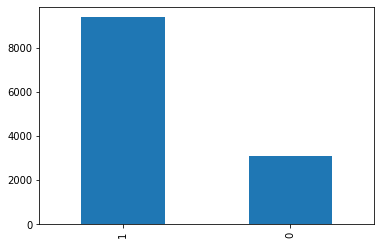

In [0]:
test_df['category'].value_counts().plot.bar()

In [0]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("../input/test1/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [0]:
submission_df2 = test_df.copy()
submission_df2['id'] = submission_df['filename'].str.split('.').str[0]
submission_df2['label'] = submission_df['category']
submission_df2.drop(['filename', 'category'], axis=1, inplace=True)
submission_df2.to_csv('../content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/cats_dogs/submission_model2.csv', index=False)

NameError: ignored

In [0]:
predict

NameError: ignored

In [0]:
#LIMEによる分析

In [0]:
#異なるモデル間でのNCによる分析
#ここ、同じモデルでパッチ数変えて分析したい

In [0]:
#NCカバー率の向上を確認

In [0]:
#精度向上


In [0]:
#augumentetionをして画像増やす
#DX使用(ランダム)
#DX occlにLIME適用
#上記でテストケースの効率を確認する

In [26]:
!ls "/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/cats_dogs/test/test/test/"

10000.jpg  11609.jpg  1966.jpg	3573.jpg  5180.jpg  6789.jpg  8396.jpg
10001.jpg  1160.jpg   1967.jpg	3574.jpg  5181.jpg  678.jpg   8397.jpg
10002.jpg  11610.jpg  1968.jpg	3575.jpg  5182.jpg  6790.jpg  8398.jpg
10003.jpg  11611.jpg  1969.jpg	3576.jpg  5183.jpg  6791.jpg  8399.jpg
10004.jpg  11612.jpg  196.jpg	3577.jpg  5184.jpg  6792.jpg  839.jpg
10005.jpg  11613.jpg  1970.jpg	3578.jpg  5185.jpg  6793.jpg  83.jpg
10006.jpg  11614.jpg  1971.jpg	3579.jpg  5186.jpg  6794.jpg  8400.jpg
10007.jpg  11615.jpg  1972.jpg	357.jpg   5187.jpg  6795.jpg  8401.jpg
10008.jpg  11616.jpg  1973.jpg	3580.jpg  5188.jpg  6796.jpg  8402.jpg
10009.jpg  11617.jpg  1974.jpg	3581.jpg  5189.jpg  6797.jpg  8403.jpg
1000.jpg   11618.jpg  1975.jpg	3582.jpg  518.jpg   6798.jpg  8404.jpg
10010.jpg  11619.jpg  1976.jpg	3583.jpg  5190.jpg  6799.jpg  8405.jpg
10011.jpg  1161.jpg   1977.jpg	3584.jpg  5191.jpg  679.jpg   8406.jpg
10012.jpg  11620.jpg  1978.jpg	3585.jpg  5192.jpg  67.jpg    8407.jpg
10013.jpg  11621.jpg  19

In [0]:
#摂動を加える犬猫画像のパスに変えたいです。
img_paths = list_pictures("/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/cats_dogs/test/test/test/")

K.set_learning_phase(0)
model_layer_dict1, model_layer_dict2, model_layer_dict3 = init_coverage_tables(model1, model2, model3)

In [28]:
img_paths

['/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/cats_dogs/test/test/test/9107.jpg',
 '/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/cats_dogs/test/test/test/9108.jpg',
 '/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/cats_dogs/test/test/test/9109.jpg',
 '/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/cats_dogs/test/test/test/911.jpg',
 '/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/cats_dogs/test/test/test/9110.jpg',
 '/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/cats_dogs/test/test/test/9111.jpg',
 '/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/cats_dogs/test/test/test/9113.jpg',
 '/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/cats_dogs/test/test/test/9114.jpg',
 '/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/cats_dogs/test/test/test/9112.jpg',
 '/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/cats_dogs/test/test/test/9115.jpg',
 

In [0]:
gen_img = (random.choice(img_paths))

In [0]:
rdm_path=random.choice(img_paths)

In [41]:
gen_img.shape

(1, 224, 224, 3)

In [0]:
pred2, pred3 = model2.predict(gen_img), model3.predict(gen_img)

In [47]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        rdm_path,
        target_size=(128, 128),
        batch_size=1,
        class_mode="categorical")

NotADirectoryError: ignored

In [43]:
import tensorflow as tf
img_raw = tf.io.read_file(img_paths)
img_tensor = tf.image.decode_image(img_raw)
img_final = tf.image.resize(img_tensor, [128, 128])

ValueError: ignored

In [48]:
path = random.choice(img_paths)
#for model1
gen_img = preprocess_image2(path)
gen_img

array([[[[ 82.061     ,  69.221     ,  68.32      ],
         [ 83.061     ,  70.221     ,  69.32      ],
         [ 84.061     ,  71.221     ,  70.32      ],
         ...,
         [101.061     ,  81.221     ,  81.32      ],
         [122.061     , 102.221     , 102.32      ],
         [122.061     , 102.221     , 102.32      ]],

        [[ 93.061     ,  80.221     ,  79.32      ],
         [ 94.061     ,  81.221     ,  80.32      ],
         [ 95.061     ,  82.221     ,  81.32      ],
         ...,
         [109.061     ,  89.221     ,  89.32      ],
         [119.061     ,  99.221     ,  99.32      ],
         [113.061     ,  93.221     ,  93.32      ]],

        [[ 85.061     ,  72.221     ,  71.32      ],
         [ 87.061     ,  74.221     ,  73.32      ],
         [ 87.061     ,  74.221     ,  73.32      ],
         ...,
         [ 99.061     ,  82.221     ,  81.32      ],
         [ 97.061     ,  80.221     ,  79.32      ],
         [106.061     ,  89.221     ,  88.32      ]],

In [29]:
###モデルの入力が異なるものに適用
path = random.choice(img_paths)
#for model1
#(1,128,128,3)に対応
gen_img_model1 = preprocess_image2(path)
#for model2
gen_img = preprocess_image(path)
orig_img = gen_img.copy()
# first check if input already induces differences
pred1, pred2, pred3 = model1.predict(gen_img_model1), model2.predict(gen_img), model3.predict(gen_img)
label1, label2, label3 = np.argmax(pred1[0]), np.argmax(pred2[0]), np.argmax(pred3[0])
if not label1 == label2 == label3:
  ######################## 摂動を加えなくても予測が3つのモデルで異なる場合の処理 Start ########################
  print('input already causes different outputs: {}, {}, {}'.format(label1, label2 ,label3) + bcolors.ENDC) 

  update_coverage(gen_img_model1, model1, model_layer_dict1, args.threshold)
  print("updatting coverage for model1")
  update_coverage(gen_img, model3, model_layer_dict3, args.threshold)
  print("updatting coverage for model3")
  update_coverage(gen_img, model2, model_layer_dict2, args.threshold)
  print("updatting coverage for model2")

  print(bcolors.OKGREEN + 'covered neurons percentage %d neurons %.3f, %d neurons %.3f, %d neurons %.3f'
  #        print('covered neurons percentage %d neurons %.3f, %d neurons %.3f, %d neurons %.3f'
        % (len(model_layer_dict1), neuron_covered(model_layer_dict1)[2], len(model_layer_dict2),
            neuron_covered(model_layer_dict2)[2], len(model_layer_dict3),
            neuron_covered(model_layer_dict3)[2]) + bcolors.ENDC)
  #                 neuron_covered(model_layer_dict3)[2]))

  averaged_nc = (neuron_covered(model_layer_dict1)[0] + neuron_covered(model_layer_dict2)[0] +
                  neuron_covered(model_layer_dict3)[0]) / float(
      neuron_covered(model_layer_dict1)[1] + neuron_covered(model_layer_dict2)[1] +
      neuron_covered(model_layer_dict3)[
          1])
  print(bcolors.OKGREEN + 'averaged covered neurons %.3f' % averaged_nc + bcolors.ENDC)
  print('averaged covered neurons %.3f' % averaged_nc)

  gen_img_deprocessed = deprocess_image(gen_img)

  # save the result to disk
  #imsave('./generated_inputs/' + 'already_differ_' + decode_label(pred1) + '_' + decode_label(
  imageio.imwrite(data_imagenet_generated + 'already_differ_' + str(label1) + '_' + str(label2) + '_' + str(label3) + '.png',
          gen_img_deprocessed)

  ######################## 摂動を加えなくても予測が3つのモデルで異なる場合の処理END ########################

######################## 予測が3つのモデルで同じ場合の処理 Start ########################
# if all label agrees
orig_label = label1
layer_name1, index1 = neuron_to_cover(model_layer_dict1)
layer_name2, index2 = neuron_to_cover(model_layer_dict2)
layer_name3, index3 = neuron_to_cover(model_layer_dict3)
# construct joint loss function
if args.target_model == 0:
    #weight_diff param
    loss1 = -args.weight_diff * K.mean(model1.get_layer('model1_output').output[..., orig_label])
    loss2 = K.mean(model2.get_layer('model2_output').output[..., orig_label])
    loss3 = K.mean(model3.get_layer('model3_output').output[..., orig_label])
elif args.target_model == 1:
    loss1 = K.mean(model1.get_layer('model1_output').output[..., orig_label])
    loss2 = -args.weight_diff * K.mean(model2.get_layer('model2_output').output[..., orig_label])
    loss3 = K.mean(model3.get_layer('model3_output').output[..., orig_label])
elif args.target_model == 2:
    loss1 = K.mean(model1.get_layer('model1_output').output[..., label1])
    loss2 = K.mean(model2.get_layer('model2_output').output[..., orig_label])
    loss3 = -args.weight_diff * K.mean(model3.get_layer('model3_output').output[..., orig_label])
loss1_neuron = K.mean(model1.get_layer(layer_name1).output[..., index1])
loss2_neuron = K.mean(model2.get_layer(layer_name2).output[..., index2])
loss3_neuron = K.mean(model3.get_layer(layer_name3).output[..., index3])
layer_output = (loss1 + loss2 + loss3) + args.weight_nc * (loss1_neuron + loss2_neuron + loss3_neuron)    

# for adversarial image generation
final_loss = K.mean(layer_output)

# we compute the gradient of the input picture wrt this loss
grads = normalize(K.gradients(final_loss, input_tensor)[0])

# this function returns the loss and grads given the input picture
iterate = K.function([input_tensor], [loss1, loss2, loss3, loss1_neuron, loss2_neuron, loss3_neuron, grads])
#    print("=============")
#    print(input_tensor)
#    print(loss1)
#    print(loss2)
#    print(loss3)
#    print(loss1_neuron)
#    print(loss2_neuron)
#    print(loss3_neuron)
#    print("=============")
#    print(gen_img.shape)

# we run gradient ascent for 20 steps
for iters in range(args.grad_iterations):
    
    ###########################error
    #iterate([gen_img])でエラーです
#        print("error ")
    loss_value1, loss_value2, loss_value3, loss_neuron1, loss_neuron2, loss_neuron3, grads_value = iterate([gen_img_model1])
#        print("error ??")
    if args.transformation == 'light':
        grads_value = constraint_light(grads_value)  # constraint the gradients value
    elif args.transformation == 'occl':
        grads_value = constraint_occl(grads_value, args.start_point,
                                      args.occlusion_size)  # constraint the gradients value
    elif args.transformation == 'blackout':
        grads_value = constraint_black(grads_value)  # constraint the gradients value

    gen_img += grads_value * args.step
    pred1, pred2, pred3 = model1.predict(gen_img), model2.predict(gen_img), model3.predict(gen_img)
    label1, label2, label3 = np.argmax(pred1[0]), np.argmax(pred2[0]), np.argmax(pred3[0])

    if not label1 == label2 == label3:
        update_coverage(gen_img, model1, model_layer_dict1, args.threshold)
        update_coverage(gen_img, model2, model_layer_dict2, args.threshold)
        update_coverage(gen_img, model3, model_layer_dict3, args.threshold)

        print(bcolors.OKGREEN + 'covered neurons percentage %d neurons %.3f, %d neurons %.3f, %d neurons %.3f'
              % (len(model_layer_dict1), neuron_covered(model_layer_dict1)[2], len(model_layer_dict2),
                  neuron_covered(model_layer_dict2)[2], len(model_layer_dict3),
                  neuron_covered(model_layer_dict3)[2]) + bcolors.ENDC)
        averaged_nc = (neuron_covered(model_layer_dict1)[0] + neuron_covered(model_layer_dict2)[0] +
                        neuron_covered(model_layer_dict3)[0]) / float(
            neuron_covered(model_layer_dict1)[1] + neuron_covered(model_layer_dict2)[1] +
            neuron_covered(model_layer_dict3)[
                1])
        print(bcolors.OKGREEN + 'averaged covered neurons %.3f' % averaged_nc + bcolors.ENDC)
        print('averaged covered neurons %.3f' % averaged_nc)

        gen_img_deprocessed = deprocess_image(gen_img)
        orig_img_deprocessed = deprocess_image(orig_img)

        # save the result to disk
        #imsave('./generated_inputs/' + args.transformation + '_' + decode_label(pred1) + '_' + decode_label(
        #0 dog,1 cat

        name_chande = lambda label1: "dog" if label1 == 1 else 'cat'
        label1 = name_chande(label1)
        label2 = name_chande(label2)
        label3 = name_chande(label3)

        if args.transformation == 'light':
          rd = randomname(6)
          grads_value = constraint_light(grads_value)  # constraint the gradients value
          imageio.imwrite(data_imagenet_generated + args.transformation + '_' + str(weight_diff) + '_' + str(weight_nc) + '_' + str(label1) + '_' + str(label2) + '_' + str(label3) + '_' + str(rd) + '.png', gen_img_deprocessed)
          #imsave('./generated_inputs/' + args.transformation + '_' + decode_label(pred1) + '_' + decode_label(
          imageio.imwrite(data_imagenet_generated + args.transformation + '_' + str(weight_diff) + '_' + str(weight_nc) + '_' + str(label1) + '_' + str(label2) + '_' + str(label3) + '_' + str(rd) + '_orig.png', orig_img_deprocessed)
        elif args.transformation == 'occl':
          rd = randomname(6)
          grads_value = constraint_occl(grads_value, args.start_point,args.occlusion_size)  # constraint the gradients value
          imageio.imwrite(data_imagenet_generated + args.transformation + '_' + str(weight_diff) + '_' + str(weight_nc) + '_' + str(sp_x) + '_' + str(sp_y) + '_' + str(occl_x) + '_' + str(occl_y) + '_' + str(label1) + '_' + str(label2) + '_' + str(label3) + '_' + str(rd) + '.png', gen_img_deprocessed)
          #imsave('./generated_inputs/' + args.transformation + '_' + decode_label(pred1) + '_' + decode_label(
          imageio.imwrite(data_imagenet_generated + args.transformation + '_' + str(weight_diff) + '_' + str(weight_nc) + '_' + str(sp_x) + '_' + str(sp_y) + '_' + str(occl_x) + '_' + str(occl_y) + '_' + str(label1) + '_' + str(label2) + '_' + str(label3) + '_' + str(rd) + '_orig.png', orig_img_deprocessed)
        elif args.transformation == 'blackout':
          rd = randomname(6)
          grads_value = constraint_black(grads_value)  # constraint the gradients value
          imageio.imwrite(data_imagenet_generated + args.transformation + '_' + str(weight_diff) + '_' + str(weight_nc) + '_' + str(label1) + '_' + str(label2) + '_' + str(label3) + '_' + str(rd) + '.png', gen_img_deprocessed)
          #imsave('./generated_inputs/' + args.transformation + '_' + decode_label(pred1) + '_' + decode_label(
          imageio.imwrite(data_imagenet_generated + args.transformation + '_' + str(weight_diff) + '_' + str(weight_nc) + '_' + str(label1) + '_' + str(label2) + '_' + str(label3) + '_' + str(rd) + '_orig.png', orig_img_deprocessed)
        break


InvalidArgumentError: ignored

In [21]:
# if all label agrees
orig_label = label1
layer_name1, index1 = neuron_to_cover(model_layer_dict1)
layer_name2, index2 = neuron_to_cover(model_layer_dict2)
layer_name3, index3 = neuron_to_cover(model_layer_dict3)
print(orig_label,layer_name1, index1,layer_name2, index2,layer_name3, index3)

0 max_pooling2d_1 12 fc2 4033 activation_43 416


In [23]:
print(loss1,loss2,loss3,loss1_neuron,loss2_neuron,loss3_neuron)


Tensor("mul_2:0", shape=(), dtype=float32) Tensor("Mean_9:0", shape=(), dtype=float32) Tensor("Mean_10:0", shape=(), dtype=float32) Tensor("Mean_11:0", shape=(), dtype=float32) Tensor("Mean_12:0", shape=(), dtype=float32) Tensor("Mean_13:0", shape=(), dtype=float32)


In [0]:

# construct joint loss function
if args.target_model == 0:
    #weight_diff param
    loss1 = -args.weight_diff * K.mean(model1.get_layer('model1_output').output[..., orig_label])
    loss2 = K.mean(model2.get_layer('model2_output').output[..., orig_label])
    loss3 = K.mean(model3.get_layer('model3_output').output[..., orig_label])
elif args.target_model == 1:
    loss1 = K.mean(model1.get_layer('model1_output').output[..., orig_label])
    loss2 = -args.weight_diff * K.mean(model2.get_layer('model2_output').output[..., orig_label])
    loss3 = K.mean(model3.get_layer('model3_output').output[..., orig_label])
elif args.target_model == 2:
    loss1 = K.mean(model1.get_layer('model1_output').output[..., label1])
    loss2 = K.mean(model2.get_layer('model2_output').output[..., orig_label])
    loss3 = -args.weight_diff * K.mean(model3.get_layer('model3_output').output[..., orig_label])
loss1_neuron = K.mean(model1.get_layer(layer_name1).output[..., index1])
loss2_neuron = K.mean(model2.get_layer(layer_name2).output[..., index2])
loss3_neuron = K.mean(model3.get_layer(layer_name3).output[..., index3])
layer_output = (loss1 + loss2 + loss3) + args.weight_nc * (loss1_neuron + loss2_neuron + loss3_neuron)    

# for adversarial image generation
final_loss = K.mean(layer_output)

# we compute the gradient of the input picture wrt this loss
grads = normalize(K.gradients(final_loss, input_tensor)[0])

# this function returns the loss and grads given the input picture
iterate = K.function([input_tensor], [loss1, loss2, loss3, loss1_neuron, loss2_neuron, loss3_neuron, grads])

In [24]:
iterate

In [25]:
loss_value1, loss_value2, loss_value3, loss_neuron1, loss_neuron2, loss_neuron3, grads_value = iterate([gen_img_model1])

InvalidArgumentError: ignored

In [19]:
loss_value1

NameError: ignored

In [20]:
[gen_img_model1]

[array([[[[-102.939   , -115.779   , -108.68    ],
          [ -41.939003,  -54.779   ,  -49.68    ],
          [ -88.939   , -100.779   ,  -97.68    ],
          ...,
          [  81.061   ,   71.221   ,   69.32    ],
          [  79.061   ,   69.221   ,   67.32    ],
          [  79.061   ,   69.221   ,   67.32    ]],
 
         [[ -79.939   ,  -92.779   ,  -85.68    ],
          [ -86.939   ,  -99.779   ,  -94.68    ],
          [-102.939   , -114.779   , -111.68    ],
          ...,
          [  81.061   ,   71.221   ,   69.32    ],
          [  82.061   ,   72.221   ,   70.32    ],
          [  83.061   ,   73.221   ,   71.32    ]],
 
         [[ -86.939   ,  -99.779   ,  -92.68    ],
          [ -83.939   ,  -96.779   ,  -91.68    ],
          [ -98.939   , -110.779   , -107.68    ],
          ...,
          [  76.061   ,   66.221   ,   64.32    ],
          [  79.061   ,   69.221   ,   67.32    ],
          [  80.061   ,   70.221   ,   68.32    ]],
 
         ...,
 
         [[ 

In [58]:
model1.get_layer(layer_name1).output[..., index1]

ValueError: ignored

In [63]:
layer_name1

'dropout_4'

In [62]:
model2.get_layer(layer_name2)

In [30]:
path = random.choice(img_paths)
#for model1
gen_img = preprocess_image2(path)
#for model2
gen_img = preprocess_image(path)
#img_paths = '/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds/dogcats/cat2.jpg'
#gen_img = preprocess_image(img_paths)
orig_img = gen_img.copy()
# first check if input already induces differences
pred1, pred2, pred3 = model1.predict(gen_img), model2.predict(gen_img), model3.predict(gen_img)
label1, label2, label3 = np.argmax(pred1[0]), np.argmax(pred2[0]), np.argmax(pred3[0])
if not label1 == label2 == label3:
  ######################## 摂動を加えなくても予測が3つのモデルで異なる場合の処理 Start ########################
  print('input already causes different outputs: {}, {}, {}'.format(label1, label2 ,label3) + bcolors.ENDC) 

  update_coverage(gen_img, model1, model_layer_dict1, args.threshold)
  print("updatting coverage for model1")
  update_coverage(gen_img, model3, model_layer_dict3, args.threshold)
  print("updatting coverage for model3")
  update_coverage(gen_img, model2, model_layer_dict2, args.threshold)
  print("updatting coverage for model2")

  print(bcolors.OKGREEN + 'covered neurons percentage %d neurons %.3f, %d neurons %.3f, %d neurons %.3f'
  #        print('covered neurons percentage %d neurons %.3f, %d neurons %.3f, %d neurons %.3f'
        % (len(model_layer_dict1), neuron_covered(model_layer_dict1)[2], len(model_layer_dict2),
            neuron_covered(model_layer_dict2)[2], len(model_layer_dict3),
            neuron_covered(model_layer_dict3)[2]) + bcolors.ENDC)
  #                 neuron_covered(model_layer_dict3)[2]))

  averaged_nc = (neuron_covered(model_layer_dict1)[0] + neuron_covered(model_layer_dict2)[0] +
                  neuron_covered(model_layer_dict3)[0]) / float(
      neuron_covered(model_layer_dict1)[1] + neuron_covered(model_layer_dict2)[1] +
      neuron_covered(model_layer_dict3)[
          1])
  print(bcolors.OKGREEN + 'averaged covered neurons %.3f' % averaged_nc + bcolors.ENDC)
  print('averaged covered neurons %.3f' % averaged_nc)

  gen_img_deprocessed = deprocess_image(gen_img)

  # save the result to disk
  #imsave('./generated_inputs/' + 'already_differ_' + decode_label(pred1) + '_' + decode_label(
  imageio.imwrite(data_imagenet_generated + 'already_differ_' + str(label1) + '_' + str(label2) + '_' + str(label3) + '.png',
          gen_img_deprocessed)

  ######################## 摂動を加えなくても予測が3つのモデルで異なる場合の処理END ########################

######################## 予測が3つのモデルで同じ場合の処理 Start ########################
# if all label agrees
orig_label = label1
layer_name1, index1 = neuron_to_cover(model_layer_dict1)
layer_name2, index2 = neuron_to_cover(model_layer_dict2)
layer_name3, index3 = neuron_to_cover(model_layer_dict3)
# construct joint loss function
if args.target_model == 0:
    #weight_diff param
    loss1 = -args.weight_diff * K.mean(model1.get_layer('model1_output').output[..., orig_label])
    loss2 = K.mean(model2.get_layer('model2_output').output[..., orig_label])
    loss3 = K.mean(model3.get_layer('model3_output').output[..., orig_label])
elif args.target_model == 1:
    loss1 = K.mean(model1.get_layer('model1_output').output[..., orig_label])
    loss2 = -args.weight_diff * K.mean(model2.get_layer('model2_output').output[..., orig_label])
    loss3 = K.mean(model3.get_layer('model3_output').output[..., orig_label])
elif args.target_model == 2:
    loss1 = K.mean(model1.get_layer('model1_output').output[..., label1])
    loss2 = K.mean(model2.get_layer('model2_output').output[..., orig_label])
    loss3 = -args.weight_diff * K.mean(model3.get_layer('model3_output').output[..., orig_label])
loss1_neuron = K.mean(model1.get_layer(layer_name1).output[..., index1])
loss2_neuron = K.mean(model2.get_layer(layer_name2).output[..., index2])
loss3_neuron = K.mean(model3.get_layer(layer_name3).output[..., index3])
layer_output = (loss1 + loss2 + loss3) + args.weight_nc * (loss1_neuron + loss2_neuron + loss3_neuron)    

# for adversarial image generation
final_loss = K.mean(layer_output)

# we compute the gradient of the input picture wrt this loss
grads = normalize(K.gradients(final_loss, input_tensor)[0])

# this function returns the loss and grads given the input picture
iterate = K.function([input_tensor], [loss1, loss2, loss3, loss1_neuron, loss2_neuron, loss3_neuron, grads])
#    print("=============")
#    print(input_tensor)
#    print(loss1)
#    print(loss2)
#    print(loss3)
#    print(loss1_neuron)
#    print(loss2_neuron)
#    print(loss3_neuron)
#    print("=============")
#    print(gen_img.shape)

# we run gradient ascent for 20 steps
for iters in range(args.grad_iterations):
    
    ###########################error
    #iterate([gen_img])でエラーです
#        print("error ")
    loss_value1, loss_value2, loss_value3, loss_neuron1, loss_neuron2, loss_neuron3, grads_value = iterate([gen_img])
#        print("error ??")
    if args.transformation == 'light':
        grads_value = constraint_light(grads_value)  # constraint the gradients value
    elif args.transformation == 'occl':
        grads_value = constraint_occl(grads_value, args.start_point,
                                      args.occlusion_size)  # constraint the gradients value
    elif args.transformation == 'blackout':
        grads_value = constraint_black(grads_value)  # constraint the gradients value

    gen_img += grads_value * args.step
    pred1, pred2, pred3 = model1.predict(gen_img), model2.predict(gen_img), model3.predict(gen_img)
    label1, label2, label3 = np.argmax(pred1[0]), np.argmax(pred2[0]), np.argmax(pred3[0])

    if not label1 == label2 == label3:
        update_coverage(gen_img, model1, model_layer_dict1, args.threshold)
        update_coverage(gen_img, model2, model_layer_dict2, args.threshold)
        update_coverage(gen_img, model3, model_layer_dict3, args.threshold)

        print(bcolors.OKGREEN + 'covered neurons percentage %d neurons %.3f, %d neurons %.3f, %d neurons %.3f'
              % (len(model_layer_dict1), neuron_covered(model_layer_dict1)[2], len(model_layer_dict2),
                  neuron_covered(model_layer_dict2)[2], len(model_layer_dict3),
                  neuron_covered(model_layer_dict3)[2]) + bcolors.ENDC)
        averaged_nc = (neuron_covered(model_layer_dict1)[0] + neuron_covered(model_layer_dict2)[0] +
                        neuron_covered(model_layer_dict3)[0]) / float(
            neuron_covered(model_layer_dict1)[1] + neuron_covered(model_layer_dict2)[1] +
            neuron_covered(model_layer_dict3)[
                1])
        print(bcolors.OKGREEN + 'averaged covered neurons %.3f' % averaged_nc + bcolors.ENDC)
        print('averaged covered neurons %.3f' % averaged_nc)

        gen_img_deprocessed = deprocess_image(gen_img)
        orig_img_deprocessed = deprocess_image(orig_img)

        # save the result to disk
        #imsave('./generated_inputs/' + args.transformation + '_' + decode_label(pred1) + '_' + decode_label(
        #0 dog,1 cat

        name_chande = lambda label1: "dog" if label1 == 1 else 'cat'
        label1 = name_chande(label1)
        label2 = name_chande(label2)
        label3 = name_chande(label3)

        if args.transformation == 'light':
          rd = randomname(6)
          grads_value = constraint_light(grads_value)  # constraint the gradients value
          imageio.imwrite(data_imagenet_generated + args.transformation + '_' + str(weight_diff) + '_' + str(weight_nc) + '_' + str(label1) + '_' + str(label2) + '_' + str(label3) + '_' + str(rd) + '.png', gen_img_deprocessed)
          #imsave('./generated_inputs/' + args.transformation + '_' + decode_label(pred1) + '_' + decode_label(
          imageio.imwrite(data_imagenet_generated + args.transformation + '_' + str(weight_diff) + '_' + str(weight_nc) + '_' + str(label1) + '_' + str(label2) + '_' + str(label3) + '_' + str(rd) + '_orig.png', orig_img_deprocessed)
        elif args.transformation == 'occl':
          rd = randomname(6)
          grads_value = constraint_occl(grads_value, args.start_point,args.occlusion_size)  # constraint the gradients value
          imageio.imwrite(data_imagenet_generated + args.transformation + '_' + str(weight_diff) + '_' + str(weight_nc) + '_' + str(sp_x) + '_' + str(sp_y) + '_' + str(occl_x) + '_' + str(occl_y) + '_' + str(label1) + '_' + str(label2) + '_' + str(label3) + '_' + str(rd) + '.png', gen_img_deprocessed)
          #imsave('./generated_inputs/' + args.transformation + '_' + decode_label(pred1) + '_' + decode_label(
          imageio.imwrite(data_imagenet_generated + args.transformation + '_' + str(weight_diff) + '_' + str(weight_nc) + '_' + str(sp_x) + '_' + str(sp_y) + '_' + str(occl_x) + '_' + str(occl_y) + '_' + str(label1) + '_' + str(label2) + '_' + str(label3) + '_' + str(rd) + '_orig.png', orig_img_deprocessed)
        elif args.transformation == 'blackout':
          rd = randomname(6)
          grads_value = constraint_black(grads_value)  # constraint the gradients value
          imageio.imwrite(data_imagenet_generated + args.transformation + '_' + str(weight_diff) + '_' + str(weight_nc) + '_' + str(label1) + '_' + str(label2) + '_' + str(label3) + '_' + str(rd) + '.png', gen_img_deprocessed)
          #imsave('./generated_inputs/' + args.transformation + '_' + decode_label(pred1) + '_' + decode_label(
          imageio.imwrite(data_imagenet_generated + args.transformation + '_' + str(weight_diff) + '_' + str(weight_nc) + '_' + str(label1) + '_' + str(label2) + '_' + str(label3) + '_' + str(rd) + '_orig.png', orig_img_deprocessed)
        break

ValueError: ignored

In [0]:
preprocess_image2

In [23]:
#画像のパス
gen_img_test = '/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds/dogcats/cat2.jpg'
local_image_path = preprocess_image(img_paths)

AttributeError: ignored

In [0]:
# ヒストグラム均一化
def equalizeHistRGB(src):
    
    RGB = cv2.split(src)
    Blue   = RGB[0]
    Green = RGB[1]
    Red    = RGB[2]
    for i in range(3):
        cv2.equalizeHist(RGB[i])

    img_hist = cv2.merge([RGB[0],RGB[1], RGB[2]])
    return img_hist

# ガウシアンノイズ
def addGaussianNoise(src):
    row,col,ch= src.shape
    mean = 0
    var = 0.1
    sigma = 15
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = src + gauss
    
    return noisy

# salt&pepperノイズ
def addSaltPepperNoise(src):
    row,col,ch = src.shape
    s_vs_p = 0.5
    amount = 0.004
    out = src.copy()
    # Salt mode
    num_salt = np.ceil(amount * src.size * s_vs_p)
    coords = [np.random.randint(0, i-1 , int(num_salt))
                 for i in src.shape]
    out[coords[:-1]] = (255,255,255)

    # Pepper mode
    num_pepper = np.ceil(amount* src.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i-1 , int(num_pepper))
             for i in src.shape]
    out[coords[:-1]] = (0,0,0)
    return out

In [0]:
#モジュールインポート
import os
import sys
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
import pprint
import urllib.error
import urllib.request

from PIL import Image
from io import BytesIO
from datetime import datetime as dt
from datetime import datetime
#from azure.cognitiveservices.vision.computervision import ComputerVisionClient
#from azure.cognitiveservices.vision.computervision.models import TextOperationStatusCodes
#from azure.cognitiveservices.vision.computervision.models import TextRecognitionMode
#from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes
#from msrest.authentication import CognitiveServicesCredentials

%matplotlib inline

In [0]:
# ルックアップテーブルの生成
min_table = 50
max_table = 205
diff_table = max_table - min_table
gamma1 = 0.75
gamma2 = 1.5

LUT_HC = np.arange(256, dtype = 'uint8' )
LUT_LC = np.arange(256, dtype = 'uint8' )
LUT_G1 = np.arange(256, dtype = 'uint8' )
LUT_G2 = np.arange(256, dtype = 'uint8' )

LUTs = []

# 平滑化用
average_square = (10,10)

# ハイコントラストLUT作成
for i in range(0, min_table):
    LUT_HC[i] = 0

for i in range(min_table, max_table):
    LUT_HC[i] = 255 * (i - min_table) / diff_table

for i in range(max_table, 255):
    LUT_HC[i] = 255

# その他LUT作成
for i in range(256):
    LUT_LC[i] = min_table + i * (diff_table) / 255
    LUT_G1[i] = 255 * pow(float(i) / 255, 1.0 / gamma1) 
    LUT_G2[i] = 255 * pow(float(i) / 255, 1.0 / gamma2)

LUTs.append(LUT_HC)
LUTs.append(LUT_LC)
LUTs.append(LUT_G1)
LUTs.append(LUT_G2)

# 画像の読み込み

img_src = cv2.imread('/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds/dogcats/cat2.jpg')
#gen_img_test = '/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds/dogcats/cat2.jpg'
#img_src = preprocess_image(img_paths)
trans_img = []
trans_img.append(img_src)

# LUT変換
for i, LUT in enumerate(LUTs):
    trans_img.append( cv2.LUT(img_src, LUT))

In [0]:
# 平滑化      
trans_img.append(cv2.blur(img_src, average_square))      

# ヒストグラム均一化
trans_img.append(equalizeHistRGB(img_src))

# ノイズ付加
trans_img.append(addGaussianNoise(img_src))
trans_img.append(addSaltPepperNoise(img_src))

# 反転
flip_img = []
for img in trans_img:
    flip_img.append(cv2.flip(img, 1))
trans_img.extend(flip_img)

# 保存
if not os.path.exists("trans_images"):
    os.mkdir("trans_images")

base =  os.path.splitext(os.path.basename(sys.argv[1]))[0] + "_"
img_src.astype(np.float64)
for i, img in enumerate(trans_img):
    # 比較用
    # cv2.imwrite("trans_images/" + base + str(i) + ".jpg" ,cv2.hconcat([img_src.astype(np.float64), img.astype(np.float64)]))
    cv2.imwrite("trans_images/" + base + str(i) + ".jpg" ,img) 


In [0]:
pred1, pred2, pred3 = model1.predict(gen_img), model2.predict(gen_img), model3.predict(gen_img)

In [0]:
#gen_img = preprocess_image(random.choice(img_paths))
img_paths = '/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds/dogcats/dog1.jpg'
gen_img = preprocess_image(img_paths)
#gen_img2 = preprocess_image2(random.choice(img_paths))
orig_img = gen_img.copy()
# first check if input already induces differences
pred1, pred2, pred3 = model1.predict(gen_img), model2.predict(gen_img), model3.predict(gen_img)
label1, label2, label3 = np.argmax(pred1[0]), np.argmax(pred2[0]), np.argmax(pred3[0])

In [0]:
pred1, pred2, pred3

In [0]:
label1, label2, label3

In [0]:
#パッケージインストール
!pip install --upgrade azure-cognitiveservices-vision-computervision

In [0]:
#モジュールインポート
import os
import sys
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
import pprint
import urllib.error
import urllib.request

from PIL import Image
from io import BytesIO
from datetime import datetime as dt
from datetime import datetime
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import TextOperationStatusCodes
from azure.cognitiveservices.vision.computervision.models import TextRecognitionMode
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes
from msrest.authentication import CognitiveServicesCredentials

%matplotlib inline

In [0]:
#環境変数に認証情報を設定
os.environ['COMPUTER_VISION_ENDPOINT'] = 'https://ai-test-customvision.cognitiveservices.azure.com/'
os.environ['COMPUTER_VISION_SUBSCRIPTION_KEY'] = 'eeb28cce620f4b1ead515ec6d1d70c4f'

In [0]:
# Add your Computer Vision subscription key and endpoint to your environment variables.
if 'COMPUTER_VISION_SUBSCRIPTION_KEY' in os.environ:
    subscription_key = os.environ['COMPUTER_VISION_SUBSCRIPTION_KEY']
else:
    print("\nSet the COMPUTER_VISION_SUBSCRIPTION_KEY environment variable.\n**Restart your shell or IDE for changes to take effect.**")
    sys.exit()

if 'COMPUTER_VISION_ENDPOINT' in os.environ:
    endpoint = os.environ['COMPUTER_VISION_ENDPOINT']

In [0]:
#APIエンドポイント,認証情報設定
computervision_client = ComputerVisionClient(os.environ['COMPUTER_VISION_ENDPOINT'], CognitiveServicesCredentials(os.environ['COMPUTER_VISION_SUBSCRIPTION_KEY']))

In [0]:
def image_analysis_local(path):
    #ローカル画像の解析
    #print("===== Tag an image - local =====")
    # Open local image file
    local_image = open(local_image_path, "rb")
    # Call API local image
    tags_result_local = computervision_client.tag_image_in_stream(local_image)

    # Print results with confidence score
    #print("Tags in the local image: ")
    global res
    res = ""
    if (len(tags_result_local.tags) == 0):
        print("No tags detected.")
    else:
        for tag in tags_result_local.tags:
            #print("'{}' with confidence {:.2f}%".format(tag.name, tag.confidence * 100))
            res = res + "'{}' with confidence {:.2f}%".format(tag.name, tag.confidence * 100) + "\n"     
    #print()
    '''
    END - Tag an image - local
    '''
    return res

In [0]:
#画像のパス
local_image_path = '/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds/dogcats/cat2.jpg'
#画像読み込み(日本語文字列不可)
src = cv2.imread('/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds/dogcats/cat2.jpg')
#入力画像出力
plt.imshow(cv2.cvtColor(src, cv2.COLOR_BGR2RGB))
print(image_analysis_local(local_image_path))

In [0]:
#gen_img = preprocess_image(random.choice(img_paths))
img_paths = out_path
gen_img = preprocess_image(img_paths)
#gen_img2 = preprocess_image2(random.choice(img_paths))
orig_img = gen_img.copy()
# first check if input already induces differences
pred1, pred2, pred3 = model1.predict(gen_img), model2.predict(gen_img), model3.predict(gen_img)
label1, label2, label3 = np.argmax(pred1[0]), np.argmax(pred2[0]), np.argmax(pred3[0])

In [0]:
pred1, pred2, pred3

In [0]:
data_imagenet_generated 

In [0]:
out_path = data_imagenet_generated + "occl_3.0_3.0_0_0_255_255_dog_cat_cat_GFrbLX.png"

In [0]:
out_path

In [0]:
sp_x = 0
sp_y = 0
occl_x = 255
occl_y = 255
parser.add_argument('-sp', '--start_point', help="occlusion upper left corner coordinate", default=(sp_x, sp_y), type=tuple)
parser.add_argument('-occl_size', '--occlusion_size', help="occlusion size", default=(occl_x, occl_y), type=tuple)
#@title ノイズのタイプ light / occl / blackout
#@body {light,occl,blackout} weight_diff weight_nc step seeds
#                   grad_iterations threshold
noise_type = "occl" #@param ["light", "occl", "blackout"]
weight_diff = "3.0" #@param {type:"string"}
weight_nc = "3.0" #@param {type:"string"}
step = "1" #@param {type:"string"}
seeds = "10" #@param {type:"string"}
grad_iterations = "100" #@param {type:"string"}
threshold = "0.1" #@param {type:"string"}
#-t = "0" #@param ["0", "1", "2"]
args = parser.parse_args([noise_type, weight_diff, weight_nc, step, seeds, grad_iterations, threshold])

In [0]:
sp_x = 0
sp_y = 0
occl_x = 125
occl_y = 125
parser.add_argument('-sp', '--start_point', help="occlusion upper left corner coordinate", default=(sp_x, sp_y), type=tuple)
parser.add_argument('-occl_size', '--occlusion_size', help="occlusion size", default=(occl_x, occl_y), type=tuple)
noise_type = "occl"
weight_diff = "3.0"
weight_nc = "3.0"
step = "1"
seeds = "10"
grad_iterations = "100"
threshold = "0.1"
args = parser.parse_args([noise_type, weight_diff, weight_nc, step, seeds, grad_iterations, threshold])

In [0]:
#gen_img = preprocess_image(random.choice(img_paths))
img_paths = '/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds/dogcats/cat2.jpg'
gen_img = preprocess_image(img_paths)
#gen_img2 = preprocess_image2(random.choice(img_paths))
orig_img = gen_img.copy()
# first check if input already induces differences
pred1, pred2, pred3 = model1.predict(gen_img), model2.predict(gen_img), model3.predict(gen_img)
label1, label2, label3 = np.argmax(pred1[0]), np.argmax(pred2[0]), np.argmax(pred3[0])
if not label1 == label2 == label3:
  ######################## 摂動を加えなくても予測が3つのモデルで異なる場合の処理 Start ########################
  print('input already causes different outputs: {}, {}, {}'.format(label1, label2 ,label3) + bcolors.ENDC) 

  update_coverage(gen_img, model1, model_layer_dict1, args.threshold)
  print("updatting coverage for model1")
  update_coverage(gen_img, model3, model_layer_dict3, args.threshold)
  print("updatting coverage for model3")
  update_coverage(gen_img, model2, model_layer_dict2, args.threshold)
  print("updatting coverage for model2")

  print(bcolors.OKGREEN + 'covered neurons percentage %d neurons %.3f, %d neurons %.3f, %d neurons %.3f'
  #        print('covered neurons percentage %d neurons %.3f, %d neurons %.3f, %d neurons %.3f'
        % (len(model_layer_dict1), neuron_covered(model_layer_dict1)[2], len(model_layer_dict2),
            neuron_covered(model_layer_dict2)[2], len(model_layer_dict3),
            neuron_covered(model_layer_dict3)[2]) + bcolors.ENDC)
  #                 neuron_covered(model_layer_dict3)[2]))

  averaged_nc = (neuron_covered(model_layer_dict1)[0] + neuron_covered(model_layer_dict2)[0] +
                  neuron_covered(model_layer_dict3)[0]) / float(
      neuron_covered(model_layer_dict1)[1] + neuron_covered(model_layer_dict2)[1] +
      neuron_covered(model_layer_dict3)[
          1])
  print(bcolors.OKGREEN + 'averaged covered neurons %.3f' % averaged_nc + bcolors.ENDC)
  print('averaged covered neurons %.3f' % averaged_nc)

  gen_img_deprocessed = deprocess_image(gen_img)

  # save the result to disk
  #imsave('./generated_inputs/' + 'already_differ_' + decode_label(pred1) + '_' + decode_label(
  imageio.imwrite(data_imagenet_generated + 'already_differ_' + str(label1) + '_' + str(label2) + '_' + str(label3) + '.png',
          gen_img_deprocessed)

  ######################## 摂動を加えなくても予測が3つのモデルで異なる場合の処理END ########################

######################## 予測が3つのモデルで同じ場合の処理 Start ########################
# if all label agrees
orig_label = label1
layer_name1, index1 = neuron_to_cover(model_layer_dict1)
layer_name2, index2 = neuron_to_cover(model_layer_dict2)
layer_name3, index3 = neuron_to_cover(model_layer_dict3)
# construct joint loss function
if args.target_model == 0:
    #weight_diff param
    loss1 = -args.weight_diff * K.mean(model1.get_layer('model1_output').output[..., orig_label])
    loss2 = K.mean(model2.get_layer('model2_output').output[..., orig_label])
    loss3 = K.mean(model3.get_layer('model3_output').output[..., orig_label])
elif args.target_model == 1:
    loss1 = K.mean(model1.get_layer('model1_output').output[..., orig_label])
    loss2 = -args.weight_diff * K.mean(model2.get_layer('model2_output').output[..., orig_label])
    loss3 = K.mean(model3.get_layer('model3_output').output[..., orig_label])
elif args.target_model == 2:
    loss1 = K.mean(model1.get_layer('model1_output').output[..., label1])
    loss2 = K.mean(model2.get_layer('model2_output').output[..., orig_label])
    loss3 = -args.weight_diff * K.mean(model3.get_layer('model3_output').output[..., orig_label])
loss1_neuron = K.mean(model1.get_layer(layer_name1).output[..., index1])
loss2_neuron = K.mean(model2.get_layer(layer_name2).output[..., index2])
loss3_neuron = K.mean(model3.get_layer(layer_name3).output[..., index3])
layer_output = (loss1 + loss2 + loss3) + args.weight_nc * (loss1_neuron + loss2_neuron + loss3_neuron)    

# for adversarial image generation
final_loss = K.mean(layer_output)

# we compute the gradient of the input picture wrt this loss
grads = normalize(K.gradients(final_loss, input_tensor)[0])

# this function returns the loss and grads given the input picture
iterate = K.function([input_tensor], [loss1, loss2, loss3, loss1_neuron, loss2_neuron, loss3_neuron, grads])
#    print("=============")
#    print(input_tensor)
#    print(loss1)
#    print(loss2)
#    print(loss3)
#    print(loss1_neuron)
#    print(loss2_neuron)
#    print(loss3_neuron)
#    print("=============")
#    print(gen_img.shape)

# we run gradient ascent for 20 steps
for iters in range(args.grad_iterations):
    
    ###########################error
    #iterate([gen_img])でエラーです
#        print("error ")
    loss_value1, loss_value2, loss_value3, loss_neuron1, loss_neuron2, loss_neuron3, grads_value = iterate([gen_img])
#        print("error ??")
    if args.transformation == 'light':
        grads_value = constraint_light(grads_value)  # constraint the gradients value
    elif args.transformation == 'occl':
        grads_value = constraint_occl(grads_value, args.start_point,
                                      args.occlusion_size)  # constraint the gradients value
    elif args.transformation == 'blackout':
        grads_value = constraint_black(grads_value)  # constraint the gradients value

    gen_img += grads_value * args.step
    pred1, pred2, pred3 = model1.predict(gen_img), model2.predict(gen_img), model3.predict(gen_img)
    label1, label2, label3 = np.argmax(pred1[0]), np.argmax(pred2[0]), np.argmax(pred3[0])

    if not label1 == label2 == label3:
        update_coverage(gen_img, model1, model_layer_dict1, args.threshold)
        update_coverage(gen_img, model2, model_layer_dict2, args.threshold)
        update_coverage(gen_img, model3, model_layer_dict3, args.threshold)

        print(bcolors.OKGREEN + 'covered neurons percentage %d neurons %.3f, %d neurons %.3f, %d neurons %.3f'
              % (len(model_layer_dict1), neuron_covered(model_layer_dict1)[2], len(model_layer_dict2),
                  neuron_covered(model_layer_dict2)[2], len(model_layer_dict3),
                  neuron_covered(model_layer_dict3)[2]) + bcolors.ENDC)
        averaged_nc = (neuron_covered(model_layer_dict1)[0] + neuron_covered(model_layer_dict2)[0] +
                        neuron_covered(model_layer_dict3)[0]) / float(
            neuron_covered(model_layer_dict1)[1] + neuron_covered(model_layer_dict2)[1] +
            neuron_covered(model_layer_dict3)[
                1])
        print(bcolors.OKGREEN + 'averaged covered neurons %.3f' % averaged_nc + bcolors.ENDC)
        print('averaged covered neurons %.3f' % averaged_nc)

        gen_img_deprocessed = deprocess_image(gen_img)
        orig_img_deprocessed = deprocess_image(orig_img)

        # save the result to disk
        #imsave('./generated_inputs/' + args.transformation + '_' + decode_label(pred1) + '_' + decode_label(
        #0 dog,1 cat

        name_chande = lambda label1: "dog" if label1 == 1 else 'cat'
        label1 = name_chande(label1)
        label2 = name_chande(label2)
        label3 = name_chande(label3)

        if args.transformation == 'light':
          rd = randomname(6)
          grads_value = constraint_light(grads_value)  # constraint the gradients value
          imageio.imwrite(data_imagenet_generated + args.transformation + '_' + str(weight_diff) + '_' + str(weight_nc) + '_' + str(label1) + '_' + str(label2) + '_' + str(label3) + '_' + str(rd) + '.png', gen_img_deprocessed)
          #imsave('./generated_inputs/' + args.transformation + '_' + decode_label(pred1) + '_' + decode_label(
          imageio.imwrite(data_imagenet_generated + args.transformation + '_' + str(weight_diff) + '_' + str(weight_nc) + '_' + str(label1) + '_' + str(label2) + '_' + str(label3) + '_' + str(rd) + '_orig.png', orig_img_deprocessed)
        elif args.transformation == 'occl':
          rd = randomname(6)
          grads_value = constraint_occl(grads_value, args.start_point,args.occlusion_size)  # constraint the gradients value
          imageio.imwrite(data_imagenet_generated + args.transformation + '_' + str(weight_diff) + '_' + str(weight_nc) + '_' + str(sp_x) + '_' + str(sp_y) + '_' + str(occl_x) + '_' + str(occl_y) + '_' + str(label1) + '_' + str(label2) + '_' + str(label3) + '_' + str(rd) + '.png', gen_img_deprocessed)
          #imsave('./generated_inputs/' + args.transformation + '_' + decode_label(pred1) + '_' + decode_label(
          imageio.imwrite(data_imagenet_generated + args.transformation + '_' + str(weight_diff) + '_' + str(weight_nc) + '_' + str(sp_x) + '_' + str(sp_y) + '_' + str(occl_x) + '_' + str(occl_y) + '_' + str(label1) + '_' + str(label2) + '_' + str(label3) + '_' + str(rd) + '_orig.png', orig_img_deprocessed)
        elif args.transformation == 'blackout':
          rd = randomname(6)
          grads_value = constraint_black(grads_value)  # constraint the gradients value
          imageio.imwrite(data_imagenet_generated + args.transformation + '_' + str(weight_diff) + '_' + str(weight_nc) + '_' + str(label1) + '_' + str(label2) + '_' + str(label3) + '_' + str(rd) + '.png', gen_img_deprocessed)
          #imsave('./generated_inputs/' + args.transformation + '_' + decode_label(pred1) + '_' + decode_label(
          imageio.imwrite(data_imagenet_generated + args.transformation + '_' + str(weight_diff) + '_' + str(weight_nc) + '_' + str(label1) + '_' + str(label2) + '_' + str(label3) + '_' + str(rd) + '_orig.png', orig_img_deprocessed)
        break